# Tube Bundle
This notebook implements the ISF algorithm to simulate inviscid fluids, governed by the incompressible Euler equations.
The mesh is generated using the *gmsh* library for Python and the ISF differential problems are solved using FEniCSx, a Finite Element library.

In [1]:
import numpy as np
from dolfinx.io.gmshio import model_to_mesh
from mpi4py import MPI
from dolfinx.io import XDMFFile

import gmsh
from petsc4py import PETSc

mesh_comm = MPI.COMM_WORLD
model_rank = 0
mesh_factor = 0.035

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('mesh/tube_bundle2D.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)
gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)
gdim = 2

# Linear Finite Element
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

Info    : Reading 'mesh/tube_bundle2D.geo'...
Info    : Done reading 'mesh/tube_bundle2D.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 40%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 50%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Circle)
Info    : [ 70%] Meshing curve 12 (Circle)
Info    : [ 70%] Meshing curve 13 (Circle)
Info    : [ 80%] Meshing curve 14 (Circle)
Info    : [ 80%] Meshing curve 15 (Circle)
Info    : [ 90%] Meshing curve 16 (Circle)
Info    : [ 90%] Meshing curve 17 (Circle)
Info    : [100%] Meshing curve 18 (Circle)
Info    : Done meshing 1D (Wall 0.0140733s, CPU 0.073203s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)


Loading the mesh

In [2]:
# Import into dolfinx
domain, _, ft = model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim = gdim )

ft.name = "Facet markers"

boundary_markers = dict()
boundary_markers['inlet']         = 10
boundary_markers['adiab_walls']   = 20
boundary_markers['coldest_walls'] = 30
boundary_markers['hottest_walls'] = 40
boundary_markers['hot_centre']    = 50
boundary_markers['cold_centre']   = 60
boundary_markers['outlet']        = 70

domain_marker = 100

# Finalize the gmsh module
gmsh.finalize()

The ISF algorithm is based on the analogy between hydrodynamics and quantum mechinacs: in fact, it can be shown thta the Euler equations
$$
\partial_t\mathbf{u}=-\left(\mathbf{u}\cdot \nabla\right)\mathbf{u} -\nabla p \qquad \text{ with } \nabla \cdot \mathbf{u} = 0
$$

are equivalent to a 2-component wave function $\Psi=[\psi_1,\psi_2]^T\in\mathbb{C}^2$, solution to Schrodinger equation
$$
i\hbar \partial_t \Psi =- 0.5 \cdot \hbar^2 \Delta \Psi + p \Psi
$$

and constrained to 
$$
\mathfrak{Re}\left\{\left(\Psi^T\right)^*i\,\Delta\Psi\right\} = 0
$$

The solution algorithm is divided into three main steps, at each time iteration:

 1) Advection: through the free-particle Schrodinger
 2) Pressure projection: Poisson problem to have a divergence free velocity
 3) Phase shift

In [3]:
import tqdm
import os

import matplotlib.pyplot as plt
from matplotlib import cm

The steps of the algorithm are imported from the `src` folder.

In [4]:
import sys
sys.path.append('../../.')

from src.prediction import schrodinger
from src.ISFvelocity import computeVelocity
from src.projection import poisson, phaseShift
from src.scalar_adv_diff import adv_diffusion

## Time Loop
An inlet velocity $\mathbf{u}_{in} = [1, 0]^T$ is used and the total simulation time is $T$, using a time step $\Delta t = 10^{-2}$.

In [6]:
# Inlet velocity
u_in = np.array([.5, 0., 0.])

# Time step
dt = 1e-2

# Equivalent viscosity
hbar = 0.01

# Assigning physical paramemeters
phys_parameters = {'uin': u_in,
                   'hbar': hbar}
gravity_dict = {'gravity': np.array([0, -9.81, 0]), 'beta': 1.0, 'Tref': 0} 

# Degree of the polynomial for FEM - the Neumann BC at the outlet for step 2 either requires a finer mesh or degree_psi = 2
degree_psi = 1

### Assembling forms #####
print('Assembling Schrodinger predict')
step1 = schrodinger(domain, ft, boundary_marks=boundary_markers, degree_psi = degree_psi, c = np.array([.5 + 0 * 1j, .5 + 0 * 1j]))
step1.assemble(phys_parameters, dt=dt, gravity_dict=gravity_dict)

print('Assembling Schrodinger velocity')
ISF_vel = computeVelocity(domain, degree_psi=degree_psi)
ISF_vel.assemble(hbar)

print('Assembling Poisson')
step2 = poisson(domain, ft, boundary_marks=boundary_markers)
bc_poisson_values = {'uin': u_in, 'fully_Neumann': False, 'is_dirichlet': True}
step2.assemble(bc_poisson_values, gauss = True)

print('Assembling Schrodinger phase-shift')
step3 = phaseShift(domain, degree_psi = degree_psi)
step3.assemble(hbar)

##### Store solution #####
store_results = False
save_tilde = False

if store_results:
    path = 'Results_Beta_'+str(gravity_dict['beta'])+'/'
    if not os.path.exists(path):
        os.system("mkdir "+path)

    psi1_xdmf = XDMFFile(domain.comm, path+"psi1.xdmf", "w")
    psi2_xdmf = XDMFFile(domain.comm, path+"psi2.xdmf", "w")
    p_xdmf = XDMFFile(domain.comm, path+"p.xdmf", "w")
    u_xdmf = XDMFFile(domain.comm, path+"U.xdmf", "w")

    psi1_xdmf.write_mesh(domain)
    psi2_xdmf.write_mesh(domain)
    p_xdmf.write_mesh(domain)
    u_xdmf.write_mesh(domain)

    if save_tilde:
        psi1_Tilde_xdmf = XDMFFile(domain.comm, path+"psi1_tilde.xdmf", "w")
        psi2_Tilde_xdmf = XDMFFile(domain.comm, path+"psi2_tilde.xdmf", "w")
        psi1_Tilde_xdmf.write_mesh(domain)
        psi2_Tilde_xdmf.write_mesh(domain)
else:
    path = None

Assembling Schrodinger predict
Assembling Schrodinger velocity
Assembling Poisson
Assembling Schrodinger phase-shift


The advection diffusion equation reads
\begin{equation}
\frac{\partial T}{\partial t} + \mathbf{u}\cdot \nabla T - \alpha \Delta T =0
\end{equation}

In [7]:
temperature_bound_marks = {
    'dirichlet' : dict(),
    'neumann'   : dict(),
    'robin'     : None
}

# Define class for passive scalar transport
_names = {'dirichlet': ['inlet', 'hot_centre', 'cold_centre'],
          'neumann': ['hottest_walls', 'coldest_walls']}
for key in list(_names.keys()):
    for name in _names[key]:
        temperature_bound_marks[key][name] = boundary_markers[name]

particles = adv_diffusion(domain, ft, temperature_bound_marks)

# Define boundaries values
assigned_temperatures = [1, 4, 0.5]
bc_values = {'dirichlet': dict(), 'neumann': dict()}
for ii in range(len(assigned_temperatures)):
    bc_values['dirichlet'][_names['dirichlet'][ii]] = PETSc.ScalarType(assigned_temperatures[ii])

assigned_heat_flux = [-0.05, 0.03]
for ii in range(len(assigned_heat_flux)):
    bc_values['neumann'][_names['neumann'][ii]] = PETSc.ScalarType(assigned_heat_flux[ii])
    
# Assembling the differential problem
particles.assemble(bc_values, dt = dt, alpha = 5e-4, T_0=gravity_dict['Tref'])

# Create file for storage
if store_results:
    T_xdmf = XDMFFile(domain.comm, path+"T.xdmf", "w")
    T_xdmf.write_mesh(domain)

Let us solve the transient.

In [8]:
from dolfinx import common

# Time parameters
T = 20.
num_steps = int(T/dt)

# Sampling rate to store the data
LL = 10

### Make contour plots
make_plots = True
if make_plots:
    transient_data = {
        'time': list(),
        'psi1': list(),
        'psi2': list(),
        'p': list(),
        'U': list(),
        'T': list()
    }
    
steps = ["1a", "1b", "1c", "2 ", "3a", "3b", "4"]
t_steps = list()
progress = tqdm.tqdm(desc="Advancing in time", total=num_steps)

for nn in range(num_steps):

    ## Step 1a: advection
    with common.Timer("~Step 1a"):
        
        if np.isclose(gravity_dict['beta'], 0):
            psi1_adv, psi2_adv = step1.advect() 
        else:
            psi1_adv, psi2_adv = step1.advect(temperature=particles.Told)

    ## Step 1b: normalisation
    with common.Timer("~Step 1b"):
        PsiTilde_1 = psi1_adv.copy()
        PsiTilde_2 = psi2_adv.copy()
        norm = np.sqrt(np.conj(psi1_adv.x.array[:]) * psi1_adv.x.array[:] + np.conj(psi2_adv.x.array[:]) * psi2_adv.x.array[:])
        PsiTilde_1.x.array[:] = psi1_adv.x.array[:] / norm.real
        PsiTilde_2.x.array[:] = psi2_adv.x.array[:] / norm.real

    ## Step 1c: compute non-solenoidal velocity
    with common.Timer("~Step 1c"):
        uTilde = ISF_vel.solve(PsiTilde_1, PsiTilde_2)

    ## Step 2: pressure projection
    with common.Timer("~Step 2 "):
        pressure = step2.solve(uTilde)

    ## Step 3a: phase shift
    with common.Timer("~Step 3a"):
        Psi_1, Psi_2 = step3.solve(PsiTilde_1, PsiTilde_2, pressure)

    ## Step 3b: compute new velocity
    with common.Timer("~Step 3b"):
        u_new = ISF_vel.solve(Psi_1, Psi_2)

    ## Step 4: Temperature advection-diffusion
    with common.Timer("~Step 4"):
        T_new = particles.solve(u_new)

    if np.isclose((nn+1) % LL, 0):
        
        if store_results:
            pressure.name = "p"
            Psi_1.name = "psi_1"
            Psi_2.name = "psi_2"
            u_new.name = "U"
            T_new.name = "T"
            p_xdmf.write_function(pressure, (nn+1) * dt)
            psi1_xdmf.write_function(Psi_1, (nn+1) * dt)
            psi2_xdmf.write_function(Psi_2, (nn+1) * dt)
            u_xdmf.write_function(u_new, (nn+1) * dt)
            T_xdmf.write_function(T_new, (nn+1) * dt)
            
            if save_tilde:
                psi1_Tilde_xdmf.write_function(PsiTilde_1, (nn+1) * dt)
                psi2_Tilde_xdmf.write_function(PsiTilde_2, (nn+1) * dt)
        
        if make_plots:
            transient_data['time'].append((nn+1) * dt)
            
            transient_data['psi1'].append(Psi_1.vector.array[:].copy())
            transient_data['psi2'].append(Psi_2.vector.array[:].copy())
            transient_data['p'].append(pressure.vector.array[:].copy())
            transient_data['T'].append(T_new.vector.array[:].copy())
            transient_data['U'].append(u_new.vector.array[:].copy())
                
    # Update Old
    with Psi_1.vector.localForm() as loc_, step1.psi1_old.vector.localForm() as loc_n:
        loc_.copy(loc_n)
    with Psi_2.vector.localForm() as loc_, step1.psi2_old.vector.localForm() as loc_n:
        loc_.copy(loc_n)

    t_steps.append(list())
    for step in steps:
        t_steps[nn].append(mesh_comm.gather(common.timing("~Step "+step), root=0))
        
    progress.update(1)

if store_results:
    p_xdmf.close()
    psi1_xdmf.close()
    psi2_xdmf.close()
    u_xdmf.close()
    T_xdmf.close()

    if save_tilde:
        psi1_Tilde_xdmf.close()
        psi2_Tilde_xdmf.close()

del progress

Advancing in time: 100%|██████████| 2000/2000 [05:18<00:00,  6.27it/s]


In the end, let us print the time required by each step during the simulation

In [9]:
if mesh_comm.rank == 0:
    print("Time-step breakdown")
    step_arr = np.asarray(t_steps)
    time_per_run = step_arr[:, :, 0, 1] / step_arr[:, :, 0, 0]
        
    for jj, step in enumerate(steps):
                print(f"Step "+step+f": Min time: {np.min(time_per_run[:, jj]):.3e}, Max time: {np.max(time_per_run[:, jj]):.3e}")

Time-step breakdown
Step 1a: Min time: 3.550e-02, Max time: 6.238e-02
Step 1b: Min time: 2.388e-04, Max time: 3.041e-04
Step 1c: Min time: 5.820e-03, Max time: 7.103e-03
Step 2 : Min time: 9.544e-02, Max time: 1.079e-01
Step 3a: Min time: 7.249e-03, Max time: 9.015e-03
Step 3b: Min time: 5.700e-03, Max time: 6.560e-03
Step 4: Min time: 5.464e-03, Max time: 5.961e-03


## Post Processing
In this section, if the data have been saved some contour plots are produced using *pyvista*.

In [11]:
import vtk
import pyvista as pv
import dolfinx

pv.start_xvfb()

In [26]:
def vector_grids(fun: dolfinx.fem.Function, mag_plot: bool, varname='u'):
    
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    grid = pv.UnstructuredGrid(topology, cells, geometry)

    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(fun)] = np.real(fun.x.array.reshape(geometry.shape[0], len(fun)))
    grid[varname] = values

    if mag_plot:
        warped = grid.warp_by_vector(varname, factor=0.0) 
    else:
        warped = grid.glyph(varname, factor=0.075, tolerance=0.015)
        
    return warped, values

def grids(fun: dolfinx.fem.Function, real = True, varname='u'):
    topology, cell_types, geometry = dolfinx.plot.vtk_mesh(fun.function_space)
    u_grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    
    if real:
        u_grid.point_data[varname] = fun.x.array[:].real
    else:
        u_grid.point_data[varname] = fun.x.array[:].imag
    u_grid.set_active_scalars(varname)
    return u_grid

def plot_wave_functions(    snaps: dict, fun_spaces: dict,
                            vars_to_plot: list[str], tex_vars: list[str], 
                            time_to_plot: int, title : str,
                            clims : list, filename: str = None, colormaps : list = None,
                            ):  
    
    nrows = 2
    ncols = len(vars_to_plot)
    assert(len(tex_vars) == nrows)
    assert(len(clims) == nrows)
    
    if colormaps is None:
        _colormaps = [cm.jet] * len(vars_to_plot)
    else:
        assert(nrows == len(colormaps))
        _colormaps = colormaps
    
    resolution = [900 * ncols, 500 * nrows]
    plotter = pv.Plotter(shape=(nrows, ncols), off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 30
    title_fontsize = 40
    zoom = 1.75
    
    dict_cb = dict( width = 0.75, height = 0.2,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    n_labels=4,
                    color = 'k',
                    position_x=0.125, position_y=0.75,
                    shadow=False) 
    
    for col in range(ncols):
        
        fun = dolfinx.fem.Function(fun_spaces[vars_to_plot[col]])
        fun.x.array[:] = snaps[vars_to_plot[col]][time_to_plot]
        
        is_real = [True, False]
        tex_real = ['\Re', '\Im']
        for row in range(nrows):
            plotter.subplot(row,col)
            
            warped_ = grids(fun, real=is_real[row], varname=vars_to_plot[col])
            dict_cb['title'] = '$'+tex_real[row]+'\{'+tex_vars[col]+'\}$'
            plotter.add_mesh(warped_, clim=clims[col], cmap=_colormaps[col], show_edges=False, scalar_bar_args=dict_cb)
            
            plotter.view_xy()
            plotter.camera.zoom(zoom)
    
    plotter.set_background('white', top='white')
    plotter.subplot(nrows-1, 0)
    plotter.add_text(title, color= 'k', position=[50, 50], font_size=30)
        
    ## Save figure
    if filename is not None:
        plotter.screenshot(filename+'.png', transparent_background = True,  window_size=resolution)
        plotter.close()
    else:
        plotter.show()

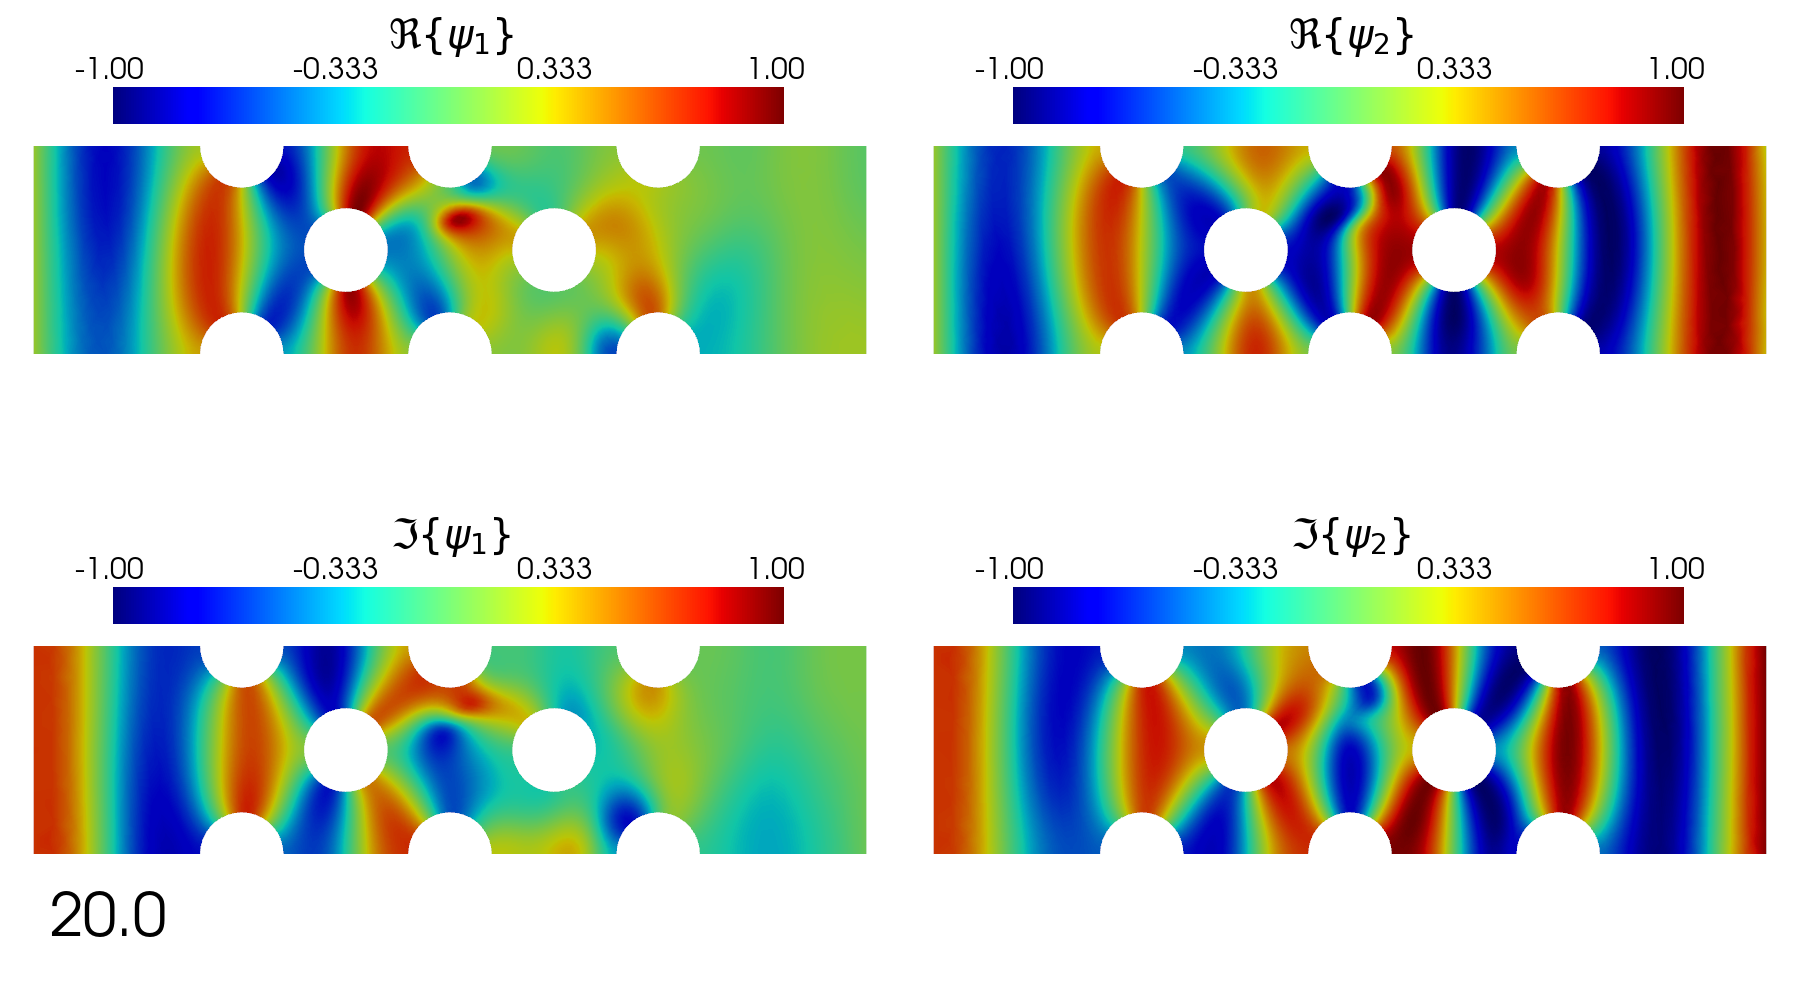

In [32]:
fun_spaces = {
    'psi1': step3.V.sub(0).collapse()[0],
    'psi2': step3.V.sub(1).collapse()[0]
}

vars_to_plot = ['psi1', 'psi2']
tex_vars_to_plot = [r'\psi_1', r'\psi_2']

clims = [
    [-1,1],
    [-1,1]
]

plot_wave_functions(transient_data, fun_spaces, vars_to_plot, tex_vars_to_plot, -1, str(transient_data['time'][-1]), clims)

In [ ]:
# if fun_spaces[vars_to_plot[col]].num_sub_spaces > 0:
#                 warped_, _ = vector_grids(fun, mag_plot=mag_plot, varname=vars_to_plot[row])
#             else:
#                 warped_ = grids(fun)
                
            
#             dict_cb['title'] = '$'+tex_vars[row]+'$'
#             if fun_spaces[vars_to_plot[col]].num_sub_spaces > 0 and mag_plot == False:
#                 warped2, _ = vector_grids(fun, mag_plot=True, varname=vars_to_plot[row])
#                 plotter.add_mesh(warped2, clim=clims[row], cmap=_colormaps[row], show_edges=False, scalar_bar_args=dict_cb)
            
#                 plotter.add_mesh(warped_, clim=clims[row], color='black', show_edges=False, scalar_bar_args=dict_cb)
#             else:
#                 plotter.add_mesh(warped_, clim=clims[row], cmap=_colormaps[row], show_edges=False, scalar_bar_args=dict_cb)
            